# Libraries

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from random import sample
import yfinance as yf
import matplotlib.pyplot as plt

# Data

In [3]:
# preprocess the data
def preprocess(data):
  data = pd.DataFrame(data)
  inc = [0]
  for i in range(1,len(data)):
    if(data['Close'][i]>data['Close'][i-1]):
      inc.append(1)
    else:
      inc.append(0)
  data = pd.DataFrame(inc)
  return data

In [4]:
#datasets
#define the ticker symbol
tickerSymbol = 'MSFT'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
data = preprocess(tickerData.history(period='1d', start='2022-1-1', end='2023-1-1')['Close'])

priorData = []
n = 22*4
for i in range(2000,2022):
  priorData.append(preprocess(tickerData.history(period='1d',start=str(i)+'-1-1',end=str(i)+'-3-1')['Close']))
  priorData.append(preprocess(tickerData.history(period='1d',start=str(i)+'-3-1',end=str(i)+'-6-1')['Close']))
  priorData.append(preprocess(tickerData.history(period='1d',start=str(i)+'-6-1',end=str(i)+'-9-1')['Close']))
  priorData.append(preprocess(tickerData.history(period='1d',start=str(i)+'-9-1',end=str(i+1)+'-1-1')['Close']))


Now we have the random variable X.

Where,
* X is proportion of price increases
* p(X = x) : Probability of there being x number of stock price increases

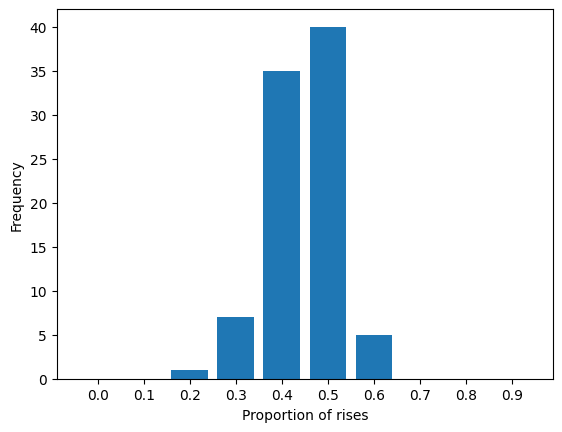

In [5]:
freq = [0]*10
prop = []
for i in range(n):
  prop.append((int(10*(priorData[i].sum()/len(priorData[i]))))/10)

x_axis = [str(i/10) for i in range(10)]

for i in range(n):
  freq[int(prop[i]*10)] = freq[int(prop[i]*10)] + 1

plt.bar(x_axis,freq)
plt.xlabel("Proportion of rises")
plt.ylabel("Frequency")
plt.show()

## MOM

Now we use MOM ( same for MLE) to fit normal distribution to the above data.

*  $E[X] = μ = \frac{1}{n}\Sigma x_i$ (Sample Mean)

*  $E[X^2] = \mu^2 + \sigma^2 = \frac{1}{n}Σ x_i^2$

where, 
* $x_i$ are i.i.d realized values of X
* $Y ∼$ 𝓝$( μ, σ)$ is the normal distribution that fits the sample data.

In [6]:
mean = np.mean(prop)
mom_2 = np.mean([i*i for i in prop])
var = mom_2 - pow(mean,2)

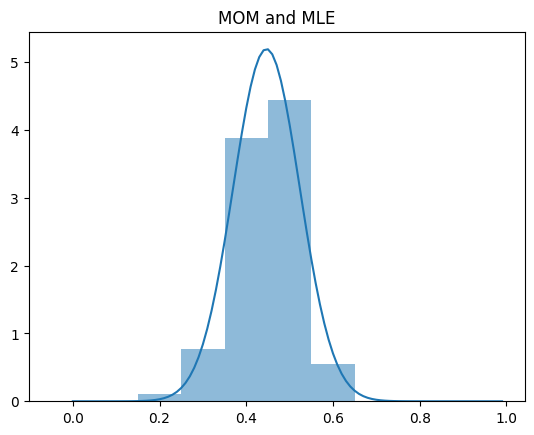

In [7]:
X_axis = [i/100 for i in range(100)]
x_axis = [i/10 for i in range(10)]
plt.plot(X_axis,stats.norm.pdf(X_axis,mean,math.sqrt(var)))
plt.bar(x_axis,[(10*i)/90 for i in freq],width = 0.1,alpha = 0.5)
plt.title("MOM and MLE")
plt.show()

#  Beta Binomial 

## Prior Distribution

First we fit a beta distribution to out give sample data which is prior distribution.

$X \sim beta(α,β)$ 

where,

* $mean = \frac{α}{\alpha + \beta}$
* $var = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$

In [8]:
mean = np.mean(prop)                             # This is first moment = mean
mom_2 = np.mean([i*i for i in prop])             # This is second moment = mean^2 + std^2
var = mom_2 - mean*mean                          # This is var = second moment - first moment
std = math.sqrt(var)                             # This is std = (var)^1/2
print("First Moment = Mean = "+str(mean))
print("Second Moment = "+str(mom_2))
print("Variance = "+str(var))
print("Standard Deviation = "+str(std))

First Moment = Mean = 0.44659090909090904
Second Moment = 0.2053409090909091
Variance = 0.0058974690082645165
Standard Deviation = 0.07679498035851377


In [9]:
alpha = ((1-mean)/var - 1/mean)*pow(mean,2)
print("alpha = "+str(alpha))

beta = alpha*(1/mean - 1)
print("beta = "+str(beta))

prior = stats.beta(alpha,beta)

alpha = 18.268863586599345
beta = 22.638515436829223


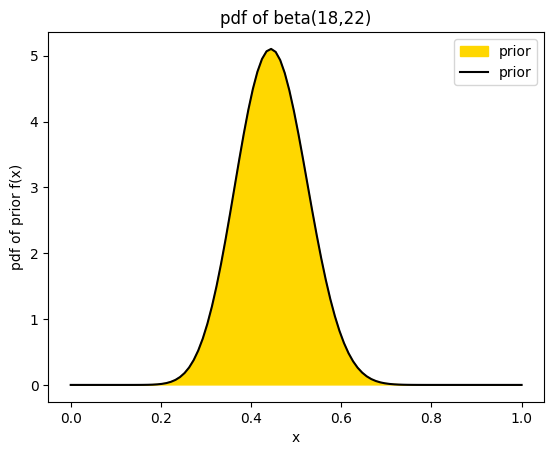

In [10]:
x_axis = np.linspace(0,1,100)
plt.fill(x_axis,prior.pdf(x_axis),color= '#FFD700',label="prior")
plt.plot(x_axis,prior.pdf(x_axis),color= 'black',label="prior")
plt.ylabel("pdf of prior f(x)")
plt.xlabel("x")
plt.title("pdf of beta("+str(int(alpha))+","+str(int(beta))+")")
plt.legend()
plt.show()

## Likelihood Distribution

Now we use the maximum likelihood funtion. In this scenario it follows binomial distribution.

<center> $L \mid π \sim Bin(n,π)$ </center>

Where, 
* n : Number of people tested
* π : Probability of a person having diabetis

In [11]:
# Size of data
n = len(data)

# Realized value of proportion of diabetic people
y = int(data.sum())
p = y/n

print("n = "+str(n))
print("y = "+str(y))
print("p = "+str(p))

likelihood = stats.binom(n,p)

n = 251
y = 116
p = 0.46215139442231074


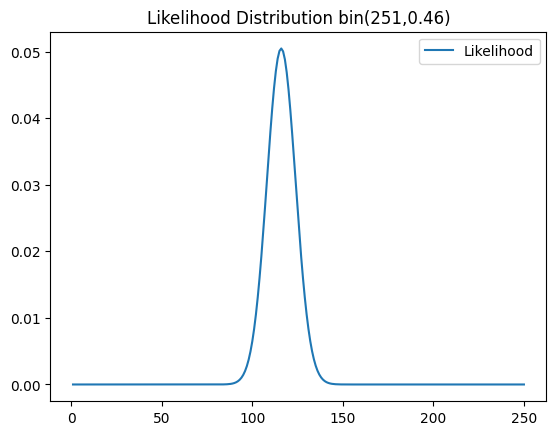

In [12]:
r_values = [i for i in range(1,n)]
# list of pmf values
dist = [stats.binom.pmf(r, n, p) for r in r_values ]
# plotting the graph 
plt.plot(r_values, dist, label = "Likelihood")
plt.title("Likelihood Distribution bin("+str(n)+","+str(int(100*p)/100)+")")
plt.legend()
plt.show()

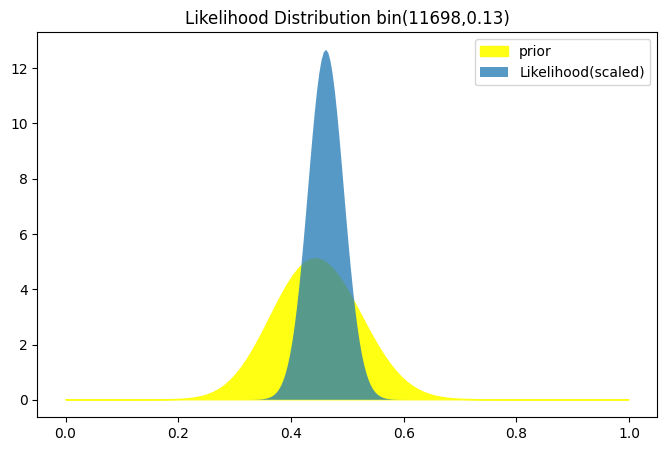

In [13]:
## combined plot
plt.figure(figsize = (8,5))
plt.fill(x_axis,prior.pdf(x_axis),color = '#FFFF14',label = "prior",alpha = 1)
plt.fill([i/n for i in r_values], [i*n for i in dist], label = "Likelihood(scaled)",alpha=0.75)
plt.title("Likelihood Distribution bin(11698,0.13)")
plt.legend()
plt.show()

In [14]:
print("Likelihood mean = " + str(p))
print("Prior mean = " + str(mean))

Likelihood mean = 0.46215139442231074
Prior mean = 0.44659090909090904


## Posterior Distribution

<center> $\pi \mid L = y \sim beta(\alpha', \beta')$ </center>

where,

* $\alpha' = \alpha + y$
* $\beta' =  \beta + n - y$
* $y$ is the realized value of number of diabetis patients in $n$ people

In [15]:
post_alpha = alpha + y
post_beta = beta + n - y
post_mean = post_alpha/(post_alpha+post_beta)
print("posterior alpha = "+str(post_alpha))
print("posterior beta = "+str(post_beta))

posterior = stats.beta(post_alpha,post_beta)
print("Posterior mean = "+str(post_mean))

posterior alpha = 134.26886358659934
posterior beta = 157.6385154368292
Posterior mean = 0.45997077578440687


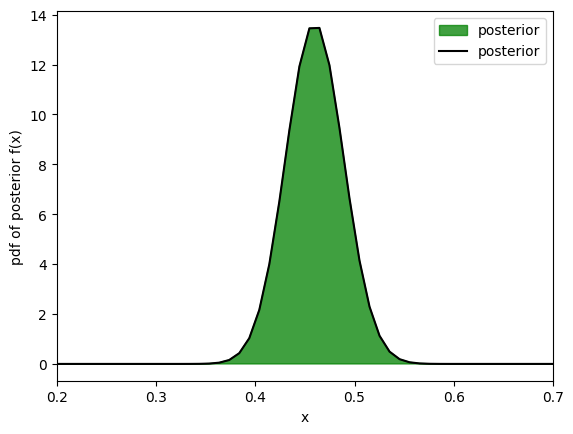

In [16]:
plt.fill(x_axis,posterior.pdf(x_axis),color= 'g',label="posterior",alpha = 0.75)
plt.plot(x_axis,posterior.pdf(x_axis),color= 'black',label="posterior")
plt.ylabel("pdf of posterior f(x)")
plt.xlabel("x")
plt.xlim(0.2,0.7)
plt.legend()
plt.show()

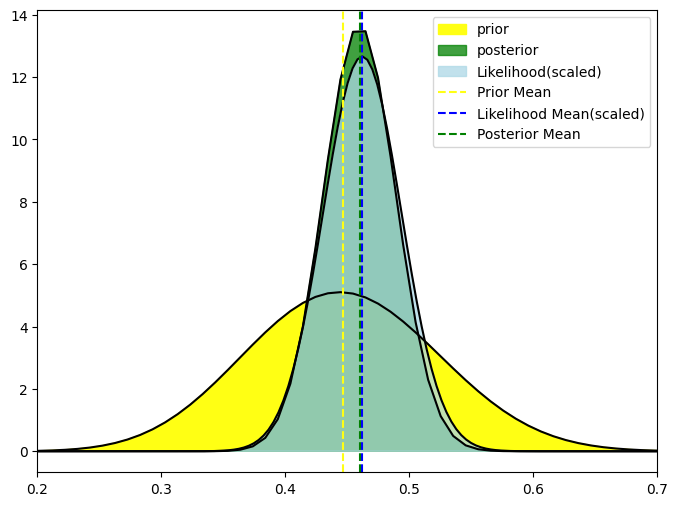

In [17]:
## combined plot
plt.figure(figsize = (8,6))
plt.fill(x_axis,prior.pdf(x_axis),color = '#FFFF14',label = "prior")
plt.fill(x_axis,posterior.pdf(x_axis),color= 'g',label="posterior",alpha = 0.75)
plt.fill([i/n for i in r_values], [i*n for i in dist],color = "#add8e6", label = "Likelihood(scaled)",alpha = 0.75)
plt.plot(x_axis,posterior.pdf(x_axis),color= 'black')
plt.plot(x_axis,prior.pdf(x_axis),color= 'black')
plt.plot([i/n for i in r_values], [i*n for i in dist],color = "black")
plt.axvline(x = mean, color = '#FFFF14',linestyle = 'dashed',label = 'Prior Mean')
plt.axvline(x = p,color = 'b',linestyle = 'dashed',label = 'Likelihood Mean(scaled)')
plt.axvline(x = post_mean,color = 'g',linestyle = 'dashed',label = 'Posterior Mean')
plt.xlim(0.2,0.7)
plt.legend()
plt.show()

In [18]:
[(post_mean-2*math.sqrt(0.000843311793395))*100,(post_mean+2*math.sqrt(0.000843311793395))*100]

[40.18911134783983, 51.80504380904155]

In [19]:
[(mean-2*std)*100, (mean+2*std)*100]

[29.300094837388148, 60.01808698079366]